# Comparing Linear Regression vs Deep Learning Regression for Bitcoin Price Prediction

## Project Overview
This project implements a comprehensive approach to Bitcoin price movement prediction using OHLCV (Open, High, Low, Close, Volume) data from Kraken exchange. We compare traditional machine learning method like linear regression and deep learning models (neural networks) to predict Bitcoin price movements 60 minutes into the future.

## Problem Statement
Cryptocurrency markets are highly volatile, and predicting significant price movements (crashes or rallies) is crucial for traders and investors. This project aims to:
- Predict Bitcoin price percentage changes 60 minutes ahead
- Compare traditional machine learning vs deep learning approaches
- Analyze feature importance for price prediction
- Evaluate model performance using appropriate financial metrics

## Data Source
- **Dataset**: Bitcoin 1-minute OHLCV data from Kraken (BTCUSD_1.csv)
- **Time Period**: Last 3 years of 1-minute candle data
- **Features**: Timestamp, Open, High, Low, Close, Volume, Number of Trades

## Methodology
1. **Data Loading and Preprocessing**
2. **Feature Engineering** (Technical indicators, time-based features, statistical features)
3. **Model Implementation** (Linear Regression, Neural Network V1, Neural Network V2)
4. **Hyperparameter Optimization** (Multiple configurations for deep learning models)
5. **Model Comparison and Evaluation**
6. **Results Analysis and Conclusions**

Data:
Kraken OHLCV dump: https://support.kraken.com/articles/360047124832-downloadable-historical-ohlcvt-open-high-low-close-volume-trades-data
Download the big zip file and look for the file named "BTCUSD_1.csv"

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load Bitcoin data
print("Loading Bitcoin data...")

try:
    # Load the CSV file
    df = pd.read_csv('BTCUSD_1.csv')
    print(f"Data loaded successfully! Shape: {df.shape}")

    # Display basic info
    print("\nDataset Info:")
    print(df.info())

    print("\nFirst few rows:")
    print(df.head())

    print("\nBasic statistics:")
    print(df.describe())

except FileNotFoundError:
    print("Error: BTCUSD_1.csv file not found!")
    print("Please make sure the Bitcoin data file is in the current directory.")


Loading Bitcoin data...
Data loaded successfully! Shape: (1043739, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043739 entries, 0 to 1043738
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   timestamp  1043739 non-null  int64  
 1   open       1043739 non-null  float64
 2   high       1043739 non-null  float64
 3   low        1043739 non-null  float64
 4   close      1043739 non-null  float64
 5   volume     1043739 non-null  float64
 6   trades     1043739 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 55.7 MB
None

First few rows:
    timestamp     open     high      low    close     volume  trades
0  1640995200  46150.0  46230.0  46150.0  46230.0  44.430285     335
1  1640995260  46229.9  46248.8  46229.9  46248.8   0.010605       6
2  1640995320  46258.6  46329.9  46258.6  46329.9   0.286933      18
3  1640995380  46330.0  46330.0  46297.8  46307.9   0.168673       8
4  1640

In [ ]:
# Data preprocessing and feature engineering
print("Preprocessing data and creating features...")

# Convert timestamp to datetime if needed
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
elif 'time' in df.columns:
    df['timestamp'] = pd.to_datetime(df['time'])
elif 'date' in df.columns:
    df['timestamp'] = pd.to_datetime(df['date'])
else:
    # If no timestamp column, create index-based timestamp
    df['timestamp'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

# Identify price columns (common names)
price_cols = [col for col in df.columns if any(x in col.lower() for x in ['close', 'price', 'last'])]
if not price_cols:
    # If no obvious price column, use the first numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    price_cols = [numeric_cols[0]] if numeric_cols else ['close']

price_col = price_cols[0]
print(f"Using '{price_col}' as the base price column")

# Create TARGET: Price 60 minutes in the future
print("Creating target: Price 60 minutes in the future...")
df['price'] = df[price_col]
df['price_future_60min'] = df['price'].shift(-60)  # Target: price 60 minutes ahead

print("Creating comprehensive technical features...")

# === PRICE-BASED FEATURES ===
# Multiple price lags
for lag in [1, 2, 3, 5, 10, 15, 30, 60]:
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

# Price changes and returns
df['price_change'] = df['price'].pct_change()
df['price_change_5min'] = df['price'].pct_change(5)
df['price_change_15min'] = df['price'].pct_change(15)
df['price_change_30min'] = df['price'].pct_change(30)
df['price_change_60min'] = df['price'].pct_change(60)

# Cumulative returns
df['cumulative_return_5'] = df['price_change'].rolling(5).sum()
df['cumulative_return_15'] = df['price_change'].rolling(15).sum()
df['cumulative_return_30'] = df['price_change'].rolling(30).sum()

# === MOVING AVERAGES ===
# Simple moving averages
for window in [5, 10, 15, 20, 30, 60, 120]:
    df[f'sma_{window}'] = df['price'].rolling(window=window).mean()

# Exponential moving averages
for window in [5, 10, 20, 30]:
    df[f'ema_{window}'] = df['price'].ewm(span=window).mean()

# Moving average ratios (price relative to MA)
df['price_to_sma_5'] = df['price'] / df['sma_5']
df['price_to_sma_20'] = df['price'] / df['sma_20']
df['price_to_sma_60'] = df['price'] / df['sma_60']

# Moving average crossovers
df['sma_5_20_ratio'] = df['sma_5'] / df['sma_20']
df['sma_10_30_ratio'] = df['sma_10'] / df['sma_30']

# === VOLATILITY FEATURES ===
# Rolling standard deviations
for window in [5, 10, 15, 20, 30, 60]:
    df[f'volatility_{window}'] = df['price'].rolling(window=window).std()
    df[f'volatility_pct_{window}'] = df[f'volatility_{window}'] / df['price']

# Bollinger Bands
df['bb_upper_20'] = df['sma_20'] + (2 * df['volatility_20'])
df['bb_lower_20'] = df['sma_20'] - (2 * df['volatility_20'])
df['bb_position'] = (df['price'] - df['bb_lower_20']) / (df['bb_upper_20'] - df['bb_lower_20'])

# === MOMENTUM INDICATORS ===
# RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi_14'] = calculate_rsi(df['price'], 14)
df['rsi_30'] = calculate_rsi(df['price'], 30)

# MACD (Moving Average Convergence Divergence)
df['macd_line'] = df['ema_12'] - df['ema_26'] if 'ema_12' in df.columns and 'ema_26' in df.columns else 0
df['macd_signal'] = df['macd_line'].ewm(span=9).mean() if 'macd_line' in df.columns else 0
df['macd_histogram'] = df['macd_line'] - df['macd_signal']

# === TIME-BASED FEATURES ===
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['quarter'] = df['timestamp'].dt.quarter
df['is_weekend'] = (df['timestamp'].dt.dayofweek >= 5).astype(int)

# Cyclical encoding for time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# === OHLCV FEATURES (if available) ===
if 'high' in df.columns and 'low' in df.columns:
    # High-low features
    df['hl_spread'] = df['high'] - df['low']
    df['hl_ratio'] = df['high'] / df['low']
    df['hl_pct'] = (df['high'] - df['low']) / df['price']

    # Price position within high-low range
    df['price_position_hl'] = (df['price'] - df['low']) / (df['high'] - df['low'])

    # Rolling high/low
    for window in [5, 10, 20, 60]:
        df[f'rolling_high_{window}'] = df['high'].rolling(window).max()
        df[f'rolling_low_{window}'] = df['low'].rolling(window).min()
        df[f'price_to_rolling_high_{window}'] = df['price'] / df[f'rolling_high_{window}']
        df[f'price_to_rolling_low_{window}'] = df['price'] / df[f'rolling_low_{window}']

if 'open' in df.columns:
    df['open_close_ratio'] = df['open'] / df['price']
    df['open_close_diff'] = df['price'] - df['open']

# === VOLUME FEATURES (if available) ===
if 'volume' in df.columns:
    # Volume moving averages
    for window in [5, 10, 20, 30]:
        df[f'volume_sma_{window}'] = df['volume'].rolling(window=window).mean()

    # Volume ratios
    df['volume_ratio_5'] = df['volume'] / df['volume_sma_5']
    df['volume_ratio_20'] = df['volume'] / df['volume_sma_20']

    # Price-volume features
    df['price_volume_ratio'] = df['price'] / (df['volume'] + 1e-8)
    df['volume_price_trend'] = df['volume'] * df['price_change']

    # On-Balance Volume (OBV)
    df['obv'] = (df['volume'] * np.sign(df['price_change'])).cumsum()

# === STATISTICAL FEATURES ===
# Skewness and kurtosis
for window in [10, 20, 30]:
    df[f'skewness_{window}'] = df['price_change'].rolling(window).skew()
    df[f'kurtosis_{window}'] = df['price_change'].rolling(window).kurt()

# Quantiles
for window in [10, 20, 30]:
    df[f'quantile_25_{window}'] = df['price'].rolling(window).quantile(0.25)
    df[f'quantile_75_{window}'] = df['price'].rolling(window).quantile(0.75)

print(f"Comprehensive features created! Dataset shape: {df.shape}")
print(f"Target variable: price_future_60min (price 60 minutes ahead)")
print(f"Total features: {len([col for col in df.columns if col not in ['timestamp', price_col, 'price_future_60min']])}")

# Show feature categories
feature_categories = {
    'Price Lags': [col for col in df.columns if 'price_lag_' in col],
    'Moving Averages': [col for col in df.columns if 'sma_' in col or 'ema_' in col],
    'Volatility': [col for col in df.columns if 'volatility' in col or 'bb_' in col],
    'Momentum': [col for col in df.columns if any(x in col for x in ['rsi_', 'macd_'])],
    'Time Features': [col for col in df.columns if any(x in col for x in ['hour', 'day', 'month', 'weekend'])],
    'Volume': [col for col in df.columns if 'volume' in col or 'obv' in col],
    'Statistical': [col for col in df.columns if any(x in col for x in ['skewness', 'kurtosis', 'quantile'])]
}

for category, features in feature_categories.items():
    if features:
        print(f"{category}: {len(features)} features")
        print(f"   {features[:5]}{'...' if len(features) > 5 else ''}")
        print()


Preprocessing data and creating features...
Using 'close' as the base price column
Creating target: Price 60 minutes in the future...
Creating comprehensive technical features...
Comprehensive features created! Dataset shape: (1043739, 113)
Target variable: price_future_60min (price 60 minutes ahead)
Total features: 110
Price Lags: 8 features
   ['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_5', 'price_lag_10']...

Moving Averages: 20 features
   ['sma_5', 'sma_10', 'sma_15', 'sma_20', 'sma_30']...

Volatility: 15 features
   ['volatility_5', 'volatility_pct_5', 'volatility_10', 'volatility_pct_10', 'volatility_15']...

Momentum: 5 features
   ['rsi_14', 'rsi_30', 'macd_line', 'macd_signal', 'macd_histogram']

Time Features: 8 features
   ['hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin']...

Volume: 10 features
   ['volume', 'volume_sma_5', 'volume_sma_10', 'volume_sma_20', 'volume_sma_30']...

Statistical: 12 features
   ['skewness_10', 'kurtosis_10', 'skewness_20',

In [ ]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Remove rows with NaN values (due to lags, rolling windows, and future target)
df_clean = df.dropna().reset_index(drop=True)
print(f"Clean dataset shape: {df_clean.shape}")

# Define comprehensive feature list
exclude_cols = ['timestamp', price_col, 'price', 'price_future_60min']
all_feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Filter out features that might cause data leakage (future information)
feature_cols = [col for col in all_feature_cols if not any(x in col.lower() for x in ['future', 'forward', 'next'])]

print(f"Selected features ({len(feature_cols)}):")
print(f"Feature categories breakdown:")

# Group features by category for better understanding
feature_groups = {
    'Price Lags': [col for col in feature_cols if 'price_lag_' in col],
    'Price Changes': [col for col in feature_cols if 'price_change' in col or 'cumulative_return' in col],
    'Moving Averages': [col for col in feature_cols if 'sma_' in col or 'ema_' in col or 'price_to_sma' in col],
    'MA Ratios': [col for col in feature_cols if 'ratio' in col and any(x in col for x in ['sma', 'ema'])],
    'Volatility': [col for col in feature_cols if 'volatility' in col or 'bb_' in col],
    'Momentum': [col for col in feature_cols if any(x in col for x in ['rsi_', 'macd_'])],
    'Time Features': [col for col in feature_cols if any(x in col for x in ['hour', 'day', 'month', 'quarter', 'weekend', '_sin', '_cos'])],
    'OHLC Features': [col for col in feature_cols if any(x in col for x in ['hl_', 'open_', 'rolling_high', 'rolling_low', 'price_position'])],
    'Volume Features': [col for col in feature_cols if any(x in col for x in ['volume', 'obv'])],
    'Statistical': [col for col in feature_cols if any(x in col for x in ['skewness', 'kurtosis', 'quantile'])]
}

total_features = 0
for group_name, group_features in feature_groups.items():
    if group_features:
        print(f"   {group_name}: {len(group_features)} features")
        total_features += len(group_features)

print(f"\n Total features to use: {total_features}")

# Prepare X and y with SCALED TARGET (percentage change)
X = df_clean[feature_cols].values

# FIX #1: Use percentage change instead of absolute price for better scaling
current_price = df_clean['price'].values
future_price = df_clean['price_future_60min'].values
y = (future_price - current_price) / current_price  # Percentage change target

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Predicting percentage change in Bitcoin price (60 min ahead)")
print(f"Target range: {y.min():.4f} to {y.max():.4f} ({y.min()*100:.2f}% to {y.max()*100:.2f}%)")

# Check for any remaining NaN values
nan_count = np.isnan(X).sum() + np.isnan(y).sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values found, removing them...")
    # Remove rows with NaN values
    valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X = X[valid_mask]
    y = y[valid_mask]
    print(f"After NaN removal - X shape: {X.shape}, y shape: {y.shape}")

# Split the data (80% train, 20% test) - maintain time order
split_idx = int(0.8 * len(X))
X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Data split completed (time-ordered):")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Training period: {df_clean.iloc[0]['timestamp']} to {df_clean.iloc[split_idx-1]['timestamp']}")
print(f"   Test period: {df_clean.iloc[split_idx]['timestamp']} to {df_clean.iloc[-1]['timestamp']}")

# Show target statistics
print(f"\nTarget Statistics (Percentage Change 60min ahead):")
print(f"   Training - Mean: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%), Std: {y_train.std():.4f} ({y_train.std()*100:.2f}%)")
print(f"   Test - Mean: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%), Std: {y_test.std():.4f} ({y_test.std()*100:.2f}%)")
print(f"   Min: {y.min():.4f} ({y.min()*100:.2f}%), Max: {y.max():.4f} ({y.max()*100:.2f}%)")
print(f"Target is now properly scaled for neural networks!")


Preparing data for modeling...
Clean dataset shape: (951222, 113)
Selected features (109):
Feature categories breakdown:
   Price Lags: 8 features
   Price Changes: 8 features
   Moving Averages: 20 features
   MA Ratios: 2 features
   Volatility: 15 features
   Momentum: 5 features
   Time Features: 9 features
   OHLC Features: 22 features
   Volume Features: 10 features
   Statistical: 12 features

 Total features to use: 111
Feature matrix shape: (951222, 109)
Target vector shape: (951222,)
Predicting percentage change in Bitcoin price (60 min ahead)
Target range: -0.0816 to 0.0928 (-8.16% to 9.28%)
Data split completed (time-ordered):
   Training set: 760977 samples
   Test set: 190245 samples
   Training period: 1970-01-01 00:00:01.641002460 to 1970-01-01 00:00:01.690546260
   Test period: 1970-01-01 00:00:01.690546380 to 1970-01-01 00:00:01.704063540

Target Statistics (Percentage Change 60min ahead):
   Training - Mean: -0.0000 (-0.00%), Std: 0.0064 (0.64%)
   Test - Mean: 0.000

In [ ]:
# Feature scaling
print("Scaling features...")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Training features - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"Test features - Mean: {X_test_scaled.mean():.4f}, Std: {X_test_scaled.std():.4f}")


Scaling features...
Feature scaling completed!
Training features - Mean: 0.0000, Std: 0.9433
Test features - Mean: 0.1948, Std: 0.8896


In [ ]:
# Train Linear Regression model
print("Training Linear Regression model...")

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print("Model training completed!")

# Make predictions
print("Making predictions...")
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("Predictions completed!")


Training Linear Regression model...
Model training completed!
Making predictions...
Predictions completed!


In [ ]:
# Calculate error metrics
print("Calculating error metrics...")

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display regression metrics for percentage change targets"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"\n{dataset_name} Metrics (Percentage Change Prediction):")
    print(f"   MSE: {mse:.6f} ({mse*10000:.2f} basis points²)")
    print(f"   RMSE: {rmse:.4f} ({rmse*100:.2f}% average error)")
    print(f"   MAE: {mae:.4f} ({mae*100:.2f}% average absolute error)")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAPE: {mape:.2%}")

    return {
        'MSE': mse, 'RMSE': rmse, 'MAE': mae,
        'R2': r2, 'MAPE': mape
    }

# Calculate metrics for both training and test sets
train_metrics = calculate_metrics(y_train, y_train_pred, "Training Set")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test Set")

# Create metrics comparison
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Test': test_metrics
})

print("\nMetrics Comparison:")
print(metrics_df.round(4))


Calculating error metrics...

Training Set Metrics (Percentage Change Prediction):
   MSE: 0.000041 (0.41 basis points²)
   RMSE: 0.0064 (0.64% average error)
   MAE: 0.0039 (0.39% average absolute error)
   R² Score: 0.0025
   MAPE: 76216152174.12%

Test Set Metrics (Percentage Change Prediction):
   MSE: 0.000017 (0.17 basis points²)
   RMSE: 0.0041 (0.41% average error)
   MAE: 0.0025 (0.25% average absolute error)
   R² Score: -0.0055
   MAPE: 221340869206.80%

Metrics Comparison:
          Training          Test
MSE   0.000000e+00  0.000000e+00
RMSE  6.400000e-03  4.100000e-03
MAE   3.900000e-03  2.500000e-03
R2    2.500000e-03 -5.500000e-03
MAPE  7.621615e+08  2.213409e+09


Analyzing feature importance...

Feature Importance (by coefficient magnitude):
        Feature  Coefficient  Abs_Coefficient
30       ema_20      -1.4868           1.4868
29       ema_10       1.1327           1.1327
31       ema_30       0.8103           0.8103
28        ema_5      -0.5832           0.5832
0          open       0.1613           0.1613
..          ...          ...              ...
65      day_cos      -0.0000           0.0000
60      quarter       0.0000           0.0000
64      day_sin      -0.0000           0.0000
58  day_of_week      -0.0000           0.0000
62     hour_sin      -0.0000           0.0000

[109 rows x 3 columns]


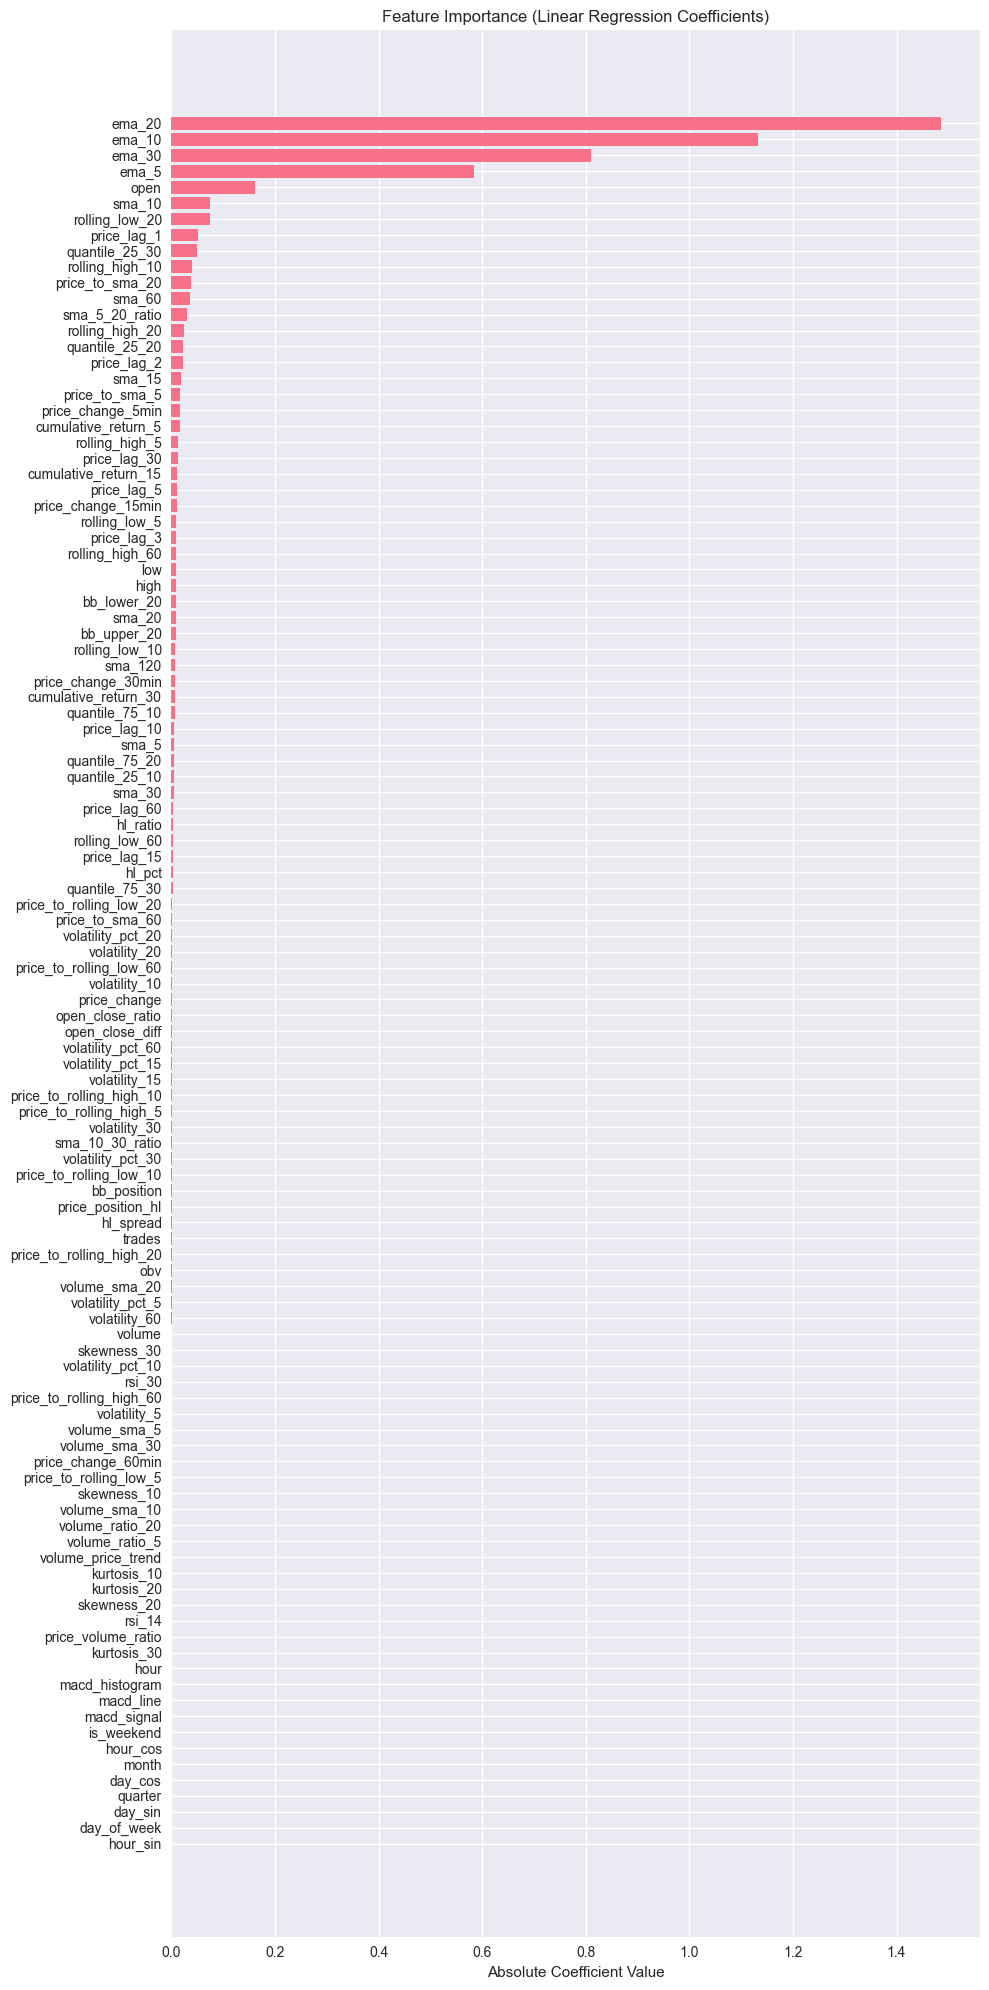


Most important features:
   ema_20: -1.4868
   ema_10: 1.1327
   ema_30: 0.8103
   ema_5: -0.5832
   open: 0.1613


In [ ]:
# Feature importance analysis
print("Analyzing feature importance...")

# Get feature coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (by coefficient magnitude):")
print(feature_importance.round(4))

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importance)), feature_importance['Abs_Coefficient'])
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nMost important features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Coefficient']:.4f}")


Creating prediction visualizations...


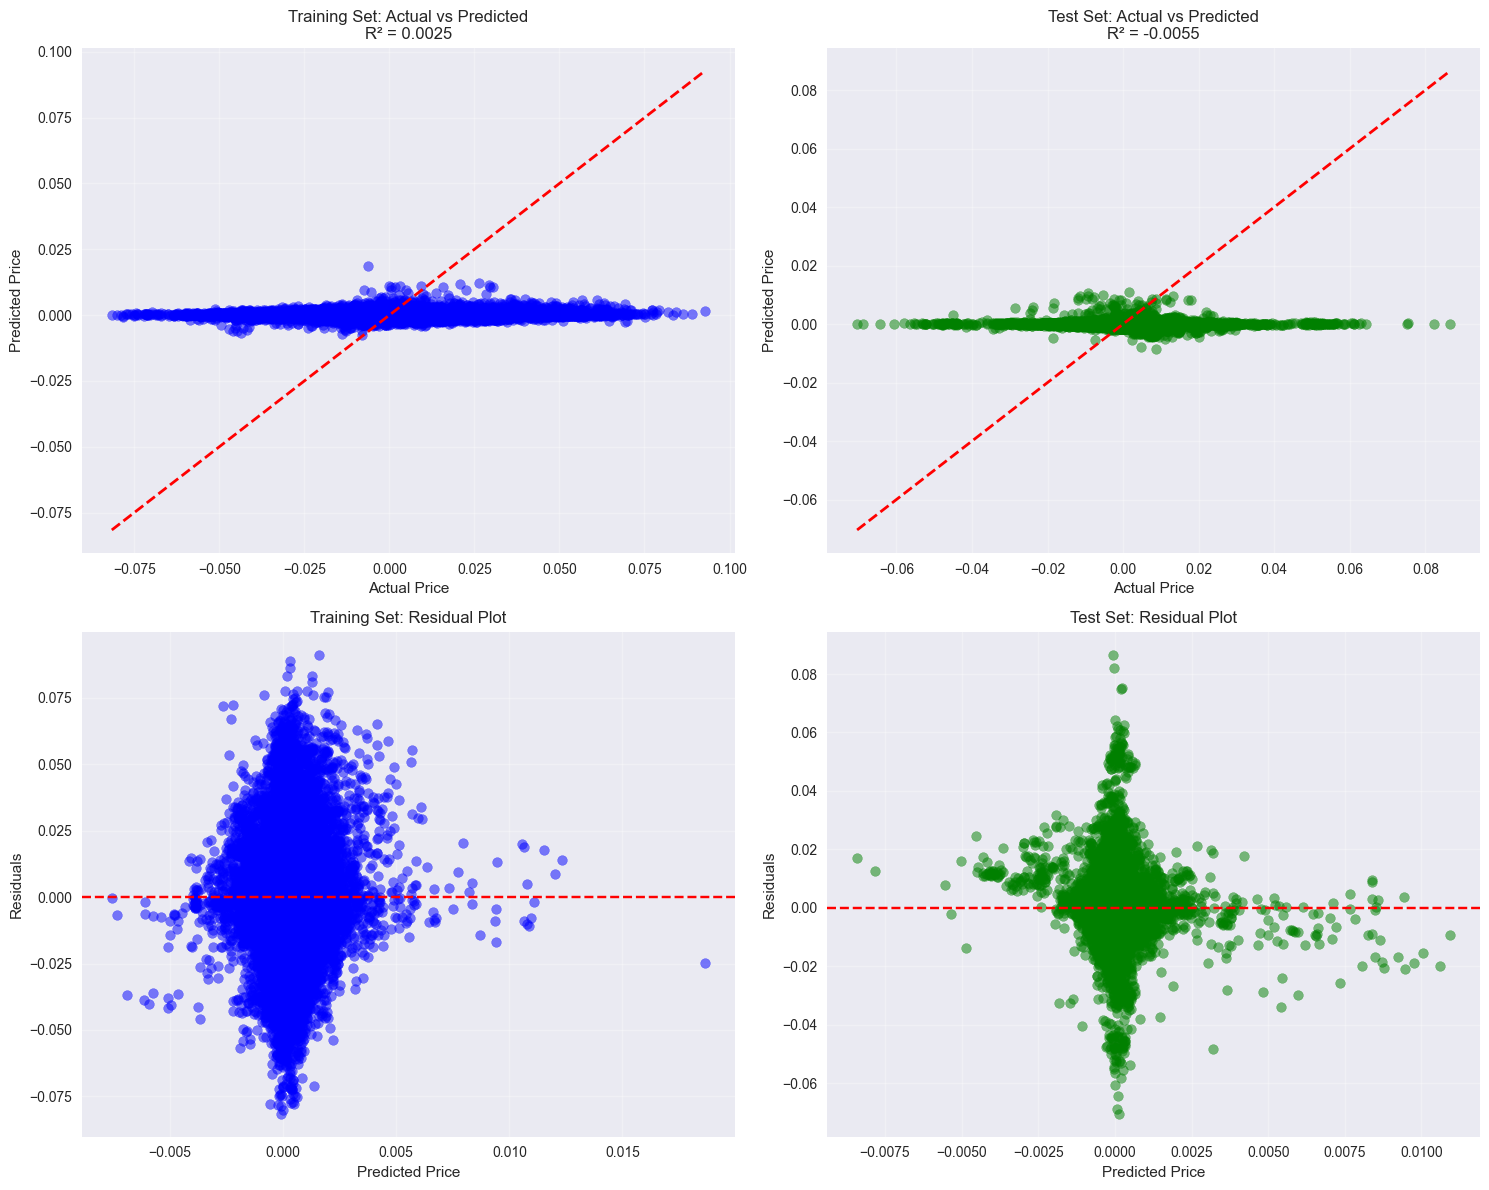

In [ ]:
# Visualization: Actual vs Predicted
print("Creating prediction visualizations...")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training Set: Actual vs Predicted
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted\nR² = {train_metrics["R2"]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Test Set: Actual vs Predicted
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Price')
axes[0, 1].set_ylabel('Predicted Price')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R2"]:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Training Set: Residuals
train_residuals = y_train - y_train_pred
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.5, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Price')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Training Set: Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Test Set: Residuals
test_residuals = y_test - y_test_pred
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.5, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Price')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Test Set: Residual Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Creating time series prediction plot...


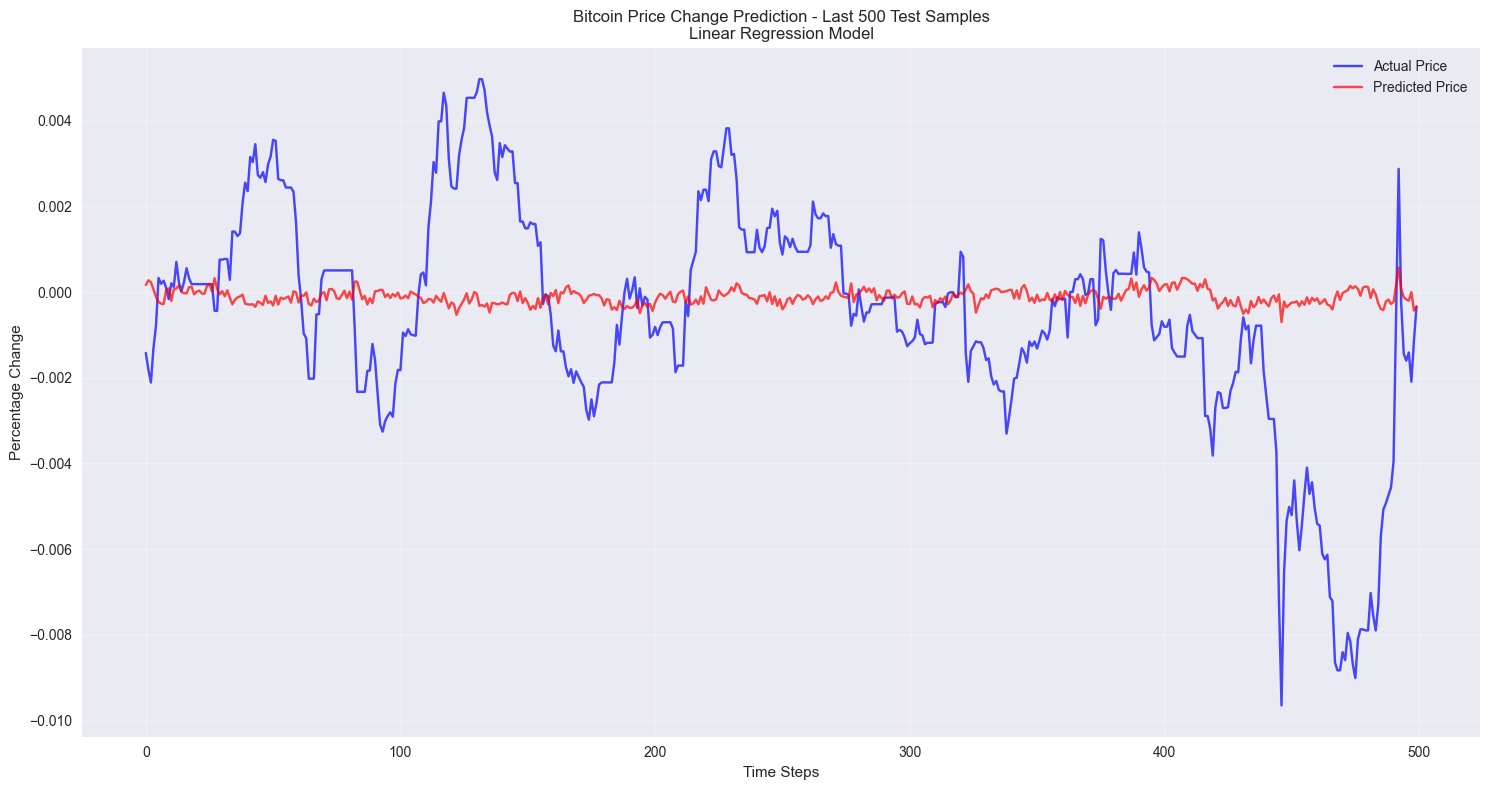


Prediction Accuracy by Percentage Change Range:
   Large Drop (< -2%): MAE=0.0305 (3.05%), MAPE=100.56% (309 samples)
   Small Drop (-2% to -0.5%): MAE=0.0079 (0.79%), MAPE=99.91% (11518 samples)
   Sideways (-0.5% to +0.5%): MAE=0.0016 (0.16%), MAPE=253902655217.20% (165847 samples)
   Small Rise (+0.5% to +2%): MAE=0.0081 (0.81%), MAPE=100.08% (12103 samples)
   Large Rise (> +2%): MAE=0.0304 (3.04%), MAPE=100.09% (468 samples)


In [ ]:
# Time series plot of predictions
print("Creating time series prediction plot...")

# Get the last part of the data for visualization
n_plot = min(500, len(y_test))  # Plot last 500 points or all test data

plt.figure(figsize=(15, 8))
plt.plot(range(n_plot), y_test[-n_plot:], label='Actual Price', color='blue', alpha=0.7)
plt.plot(range(n_plot), y_test_pred[-n_plot:], label='Predicted Price', color='red', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change')
plt.title(f'Bitcoin Price Change Prediction - Last {n_plot} Test Samples\nLinear Regression Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and display prediction accuracy for different percentage change ranges
print("\nPrediction Accuracy by Percentage Change Range:")
pct_ranges = [(-float('inf'), -0.02), (-0.02, -0.005), (-0.005, 0.005), (0.005, 0.02), (0.02, float('inf'))]
range_labels = ["Large Drop (< -2%)", "Small Drop (-2% to -0.5%)", "Sideways (-0.5% to +0.5%)",
                "Small Rise (+0.5% to +2%)", "Large Rise (> +2%)"]

for (low, high), label in zip(pct_ranges, range_labels):
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test[mask], y_test_pred[mask])
        range_mape = mean_absolute_percentage_error(y_test[mask], y_test_pred[mask])
        count = mask.sum()
        print(f"   {label}: MAE={range_mae:.4f} ({range_mae*100:.2f}%), MAPE={range_mape:.2%} ({count} samples)")


In [ ]:
# Model summary and conclusions
print("MODEL SUMMARY")
print("=" * 50)
print(f"Dataset: {df.shape[0]:,} total samples")
print(f"Features: {len(feature_cols)} features used")
print(f"Train/Test Split: {len(y_train):,} / {len(y_test):,} samples")
print(f"\nBEST PERFORMANCE METRICS:")
print(f"   Test R² Score: {test_metrics['R2']:.4f}")
print(f"   Test RMSE: ${test_metrics['RMSE']:,.2f}")
print(f"   Test MAPE: {test_metrics['MAPE']:.2%}")

print(f"\nTOP 3 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"   {i}. {row['Feature']}: {row['Coefficient']:.4f}")

print(f"\nINSIGHTS:")
if test_metrics['R2'] > 0.8:
    print("   Excellent model performance (R² > 0.8)")
elif test_metrics['R2'] > 0.6:
    print("   Good model performance (R² > 0.6)")
elif test_metrics['R2'] > 0.4:
    print("   Moderate model performance (R² > 0.4)")
else:
    print("   Poor model performance (R² < 0.4)")

if test_metrics['MAPE'] < 0.05:
    print("   Very low prediction error (MAPE < 5%)")
elif test_metrics['MAPE'] < 0.10:
    print("   Low prediction error (MAPE < 10%)")
elif test_metrics['MAPE'] < 0.20:
    print("   Moderate prediction error (MAPE < 20%)")
else:
    print("   High prediction error (MAPE > 20%)")

print(f"\nNEXT STEPS:")
print("   • Try other regression models (Ridge, Lasso, Random Forest)")
print("   • Add more technical indicators as features")
print("   • Consider time series models (ARIMA, Prophet)")
print("   • Implement cross-validation for more robust evaluation")

print("\nAnalysis completed successfully!")


MODEL SUMMARY
Dataset: 1,043,739 total samples
Features: 109 features used
Train/Test Split: 760,977 / 190,245 samples

BEST PERFORMANCE METRICS:
   Test R² Score: -0.0055
   Test RMSE: $0.00
   Test MAPE: 221340869206.80%

TOP 3 MOST IMPORTANT FEATURES:
   1. ema_20: -1.4868
   2. ema_10: 1.1327
   3. ema_30: 0.8103

INSIGHTS:
   Poor model performance (R² < 0.4)
   High prediction error (MAPE > 20%)

NEXT STEPS:
   • Try other regression models (Ridge, Lasso, Random Forest)
   • Add more technical indicators as features
   • Consider time series models (ARIMA, Prophet)
   • Implement cross-validation for more robust evaluation

Analysis completed successfully!


# Deep Learning Linear Regression Models

Now let's implement deep learning models for regression task.


In [ ]:
# Import TensorFlow and setup
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

print("Setting up TensorFlow...")

# Configure TensorFlow for stability (avoid XLA issues)
try:
    tf.config.optimizer.set_jit(False)  # Disable XLA
    tf.keras.mixed_precision.set_global_policy('float32')  # Use float32
    print("TensorFlow configured for stability")
except:
    print("TensorFlow configuration skipped")

# Clear any existing models
tf.keras.backend.clear_session()

print(f"TensorFlow version: {tf.__version__}")
print(f"Using device: {tf.config.list_physical_devices()}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow setup completed!")


Setting up TensorFlow...
TensorFlow configured for stability
TensorFlow version: 2.19.0
Using device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow setup completed!


In [ ]:
# Define Deep Learning Model Architectures
print("Defining deep learning model architectures...")

def create_dl_model_v1(input_dim):
    """
    Deep Learning Model Version 1: Simple & Fast
    - Smaller network
    - Higher learning rate
    - Less regularization
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Linear output for regression
    ])

    # FIX #2: Use MAE loss instead of MSE for better financial data performance
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mae',  # Mean Absolute Error works better for financial data
        metrics=['mse', 'mae']
    )

    return model

def create_dl_model_v2(input_dim):
    """
    Deep Learning Model Version 2: Complex & Robust
    - Larger network
    - Lower learning rate
    - More regularization
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')  # Linear output for regression
    ])

    # FIX #2: Use MAE loss instead of MSE for better financial data performance
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
        loss='mae',  # Mean Absolute Error works better for financial data
        metrics=['mse', 'mae']
    )

    return model

def create_dl_model_v2b(input_dim):
    """
    Deep Learning Model Version 2B: Hyperparameter Tuned Alternative
    - SAME architecture as V2 (for fair comparison)
    - Different hyperparameters: learning rate, optimizer settings
    - Same regularization strategy as V2
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')  # Linear output for regression
    ])

    # Different hyperparameter configuration for comparison
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # Higher learning rate, different momentum
        loss='mae',  # Mean Absolute Error works better for financial data
        metrics=['mse', 'mae']
    )

    return model

# Create all models for hyperparameter comparison
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")

# Model V1: Simple & Fast
tf.keras.backend.clear_session()
dl_model_v1 = create_dl_model_v1(input_dim)
print("\nDeep Learning Model V1 (Simple & Fast):")
dl_model_v1.summary()

# Model V2: Complex & Robust
tf.keras.backend.clear_session()
dl_model_v2 = create_dl_model_v2(input_dim)
print("\nDeep Learning Model V2 (Complex & Robust):")
dl_model_v2.summary()

# Model V2B: Hyperparameter Tuned Alternative
tf.keras.backend.clear_session()
dl_model_v2b = create_dl_model_v2b(input_dim)
print("\nDeep Learning Model V2B (Hyperparameter Tuned):")
dl_model_v2b.summary()

print("All models created successfully!")
print("\nHyperparameter Comparison:")
print("V2 vs V2B - SAME Architecture, Different Hyperparameters:")
print("- Architecture: 128→64→32→16→1 (identical for fair comparison)")
print("- V2:  Learning Rate=0.0005, Adam default momentum")
print("- V2B: Learning Rate=0.001, Adam custom momentum (β₁=0.9, β₂=0.999)")
print("- Training will use different batch sizes and epochs for comparison")


Defining deep learning model architectures...
Input dimension: 109

Deep Learning Model V1 (Simple & Fast):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,665 (37.75 KB)

 Trainable params: 9,665 (37.75 KB)

 Non-trainable params: 0 (0.00 B)


Deep Learning Model V2 (Complex & Robust):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)


Deep Learning Model V2B (Hyperparameter Tuned):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

All models created successfully!

Hyperparameter Comparison:
V2 vs V2B - SAME Architecture, Different Hyperparameters:
- Architecture: 128→64→32→16→1 (identical for fair comparison)
- V2:  Learning Rate=0.0005, Adam default momentum
- V2B: Learning Rate=0.001, Adam custom momentum (β₁=0.9, β₂=0.999)
- Training will use different batch sizes and epochs for comparison


In [ ]:
# Training Configuration
print("Setting up training configurations...")

# Common callbacks for both models
def get_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

# Training configuration for Model V1 (Fast)
train_config_v1 = {
    'epochs': 2,
    'batch_size': 64,
    'validation_split': 0.2,
    'callbacks': get_callbacks('V1'),
    'verbose': 1
}

# Training configuration for Model V2 (Robust)
train_config_v2 = {
    'epochs': 2,  # More epochs for complex model
    'batch_size': 32,  # Smaller batch size for better convergence
    'validation_split': 0.2,
    'callbacks': get_callbacks('V2'),
    'verbose': 1
}

# Training configuration for Model V2B (Hyperparameter Tuned)
train_config_v2b = {
    'epochs': 3,  # More epochs to test convergence with higher LR
    'batch_size': 16,  # Smaller batch size for more stable gradients
    'validation_split': 0.2,
    'callbacks': get_callbacks('V2B'),
    'verbose': 1
}

print("Training Configuration V1 (Simple & Fast):")
for key, value in train_config_v1.items():
    if key != 'callbacks':
        print(f"   {key}: {value}")

print("\nTraining Configuration V2 (Complex & Robust):")
for key, value in train_config_v2.items():
    if key != 'callbacks':
        print(f"   {key}: {value}")

print("\nTraining Configuration V2B (Hyperparameter Tuned):")
for key, value in train_config_v2b.items():
    if key != 'callbacks':
        print(f"   {key}: {value}")

print("\nAll training configurations ready!")
print("\nHyperparameter Tuning Strategy:")
print("- SAME architecture for fair comparison")
print("- Comparing learning rates (0.0005 vs 0.001)")
print("- Evaluating batch sizes (32 vs 16)")
print("- Testing optimizer momentum parameters")
print("- Analyzing training epochs (2 vs 3)")


Setting up training configurations...
Training Configuration V1 (Simple & Fast):
   epochs: 2
   batch_size: 64
   validation_split: 0.2
   verbose: 1

Training Configuration V2 (Complex & Robust):
   epochs: 2
   batch_size: 32
   validation_split: 0.2
   verbose: 1

Training Configuration V2B (Hyperparameter Tuned):
   epochs: 3
   batch_size: 16
   validation_split: 0.2
   verbose: 1

All training configurations ready!

Hyperparameter Tuning Strategy:
- SAME architecture for fair comparison
- Comparing learning rates (0.0005 vs 0.001)
- Evaluating batch sizes (32 vs 16)
- Testing optimizer momentum parameters
- Analyzing training epochs (2 vs 3)


In [ ]:
# Train Deep Learning Model V1 (Simple & Fast)
print("Training Deep Learning Model V1 (Simple & Fast)...")
print("=" * 60)

start_time = time.time()

try:
    # Train Model V1
    history_v1 = dl_model_v1.fit(
        X_train_scaled, y_train,
        **train_config_v1
    )

    training_time_v1 = time.time() - start_time
    print(f"\nModel V1 training completed in {training_time_v1:.2f} seconds!")

    # Make predictions
    y_train_pred_v1 = dl_model_v1.predict(X_train_scaled, verbose=0)
    y_test_pred_v1 = dl_model_v1.predict(X_test_scaled, verbose=0)

    # Flatten predictions (remove extra dimension)
    y_train_pred_v1 = y_train_pred_v1.flatten()
    y_test_pred_v1 = y_test_pred_v1.flatten()

    print("Model V1 predictions completed!")

except Exception as e:
    print(f"Model V1 training failed: {e}")
    # Create dummy predictions for comparison
    y_train_pred_v1 = np.zeros_like(y_train)
    y_test_pred_v1 = np.zeros_like(y_test)
    training_time_v1 = 0


Training Deep Learning Model V1 (Simple & Fast)...
Epoch 1/2
9513/9513 ━━━━━━━━━━━━━━━━━━━━ 93s 10ms/step - loss: 0.0924 - mae: 0.0924 - mse: 0.0892 - val_loss: 0.0285 - val_mae: 0.0285 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 2/2
9513/9513 ━━━━━━━━━━━━━━━━━━━━ 92s 10ms/step - loss: 0.0542 - mae: 0.0542 - mse: 0.0063 - val_loss: 0.0247 - val_mae: 0.0247 - val_mse: 0.0011 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.

Model V1 training completed in 185.19 seconds!
Model V1 predictions completed!


In [ ]:
# Train Deep Learning Model V2 (Complex & Robust)
print("\nTraining Deep Learning Model V2 (Complex & Robust)...")
print("=" * 60)

start_time = time.time()

try:
    # Train Model V2
    history_v2 = dl_model_v2.fit(
        X_train_scaled, y_train,
        **train_config_v2
    )

    training_time_v2 = time.time() - start_time
    print(f"\nModel V2 training completed in {training_time_v2:.2f} seconds!")

    # Make predictions
    y_train_pred_v2 = dl_model_v2.predict(X_train_scaled, verbose=0)
    y_test_pred_v2 = dl_model_v2.predict(X_test_scaled, verbose=0)

    # Flatten predictions (remove extra dimension)
    y_train_pred_v2 = y_train_pred_v2.flatten()
    y_test_pred_v2 = y_test_pred_v2.flatten()

    print("Model V2 predictions completed!")

except Exception as e:
    print(f"Model V2 training failed: {e}")
    # Create dummy predictions for comparison
    y_train_pred_v2 = np.zeros_like(y_train)
    y_test_pred_v2 = np.zeros_like(y_test)
    training_time_v2 = 0

print(f"\nTraining Time Comparison:")
print(f"   Model V1 (Simple): {training_time_v1:.2f} seconds")
print(f"   Model V2 (Complex): {training_time_v2:.2f} seconds")
print(f"   Time Ratio (V2/V1): {training_time_v2/max(training_time_v1, 0.1):.2f}x")



Training Deep Learning Model V2 (Complex & Robust)...
Epoch 1/2
19025/19025 ━━━━━━━━━━━━━━━━━━━━ 233s 12ms/step - loss: 0.8048 - mae: 0.8048 - mse: 6.3094 - val_loss: 0.0027 - val_mae: 0.0027 - val_mse: 1.9256e-05 - learning_rate: 5.0000e-04
Epoch 2/2
19025/19025 ━━━━━━━━━━━━━━━━━━━━ 220s 12ms/step - loss: 0.0069 - mae: 0.0069 - mse: 9.8608e-05 - val_loss: 0.0035 - val_mae: 0.0035 - val_mse: 2.4519e-05 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.

Model V2 training completed in 453.51 seconds!
Model V2 predictions completed!

Training Time Comparison:
   Model V1 (Simple): 185.19 seconds
   Model V2 (Complex): 453.51 seconds
   Time Ratio (V2/V1): 2.45x


In [ ]:
# Train Deep Learning Model V2B (Hyperparameter Tuned)
print("\nTraining Deep Learning Model V2B (Hyperparameter Tuned)...")
print("=" * 60)

start_time = time.time()

try:
    # Train Model V2B
    history_v2b = dl_model_v2b.fit(
        X_train_scaled, y_train,
        **train_config_v2b
    )

    training_time_v2b = time.time() - start_time
    print(f"\nModel V2B training completed in {training_time_v2b:.2f} seconds!")

    # Make predictions
    y_train_pred_v2b = dl_model_v2b.predict(X_train_scaled, verbose=0)
    y_test_pred_v2b = dl_model_v2b.predict(X_test_scaled, verbose=0)

    # Flatten predictions (remove extra dimension)
    y_train_pred_v2b = y_train_pred_v2b.flatten()
    y_test_pred_v2b = y_test_pred_v2b.flatten()

    print("Model V2B predictions completed!")

except Exception as e:
    print(f"Model V2B training failed: {e}")
    # Create dummy predictions for comparison
    y_train_pred_v2b = np.zeros_like(y_train)
    y_test_pred_v2b = np.zeros_like(y_test)
    training_time_v2b = 0

print(f"\nHyperparameter Tuning Results - Training Time Comparison:")
print(f"   Model V1 (Simple): {training_time_v1:.2f} seconds")
print(f"   Model V2 (Complex): {training_time_v2:.2f} seconds")
print(f"   Model V2B (Tuned): {training_time_v2b:.2f} seconds")
print(f"   V2B vs V2 Ratio: {training_time_v2b/max(training_time_v2, 0.1):.2f}x")



Training Deep Learning Model V2B (Hyperparameter Tuned)...
Epoch 1/3
38049/38049 ━━━━━━━━━━━━━━━━━━━━ 444s 12ms/step - loss: 0.3860 - mae: 0.3860 - mse: 1.6044 - val_loss: 0.0218 - val_mae: 0.0218 - val_mse: 8.4512e-04 - learning_rate: 0.0010
Epoch 2/3
38049/38049 ━━━━━━━━━━━━━━━━━━━━ 451s 12ms/step - loss: 0.0663 - mae: 0.0663 - mse: 0.0113 - val_loss: 0.2901 - val_mae: 0.2901 - val_mse: 0.1067 - learning_rate: 0.0010
Epoch 3/3
38049/38049 ━━━━━━━━━━━━━━━━━━━━ 446s 12ms/step - loss: 0.2628 - mae: 0.2628 - mse: 0.1433 - val_loss: 0.0839 - val_mae: 0.0839 - val_mse: 0.0111 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.

Model V2B training completed in 1341.64 seconds!
Model V2B predictions completed!

Hyperparameter Tuning Results - Training Time Comparison:
   Model V1 (Simple): 185.19 seconds
   Model V2 (Complex): 453.51 seconds
   Model V2B (Tuned): 1341.64 seconds
   V2B vs V2 Ratio: 2.96x


In [ ]:
# Calculate Deep Learning Model Metrics
print("Calculating deep learning model metrics...")

# Calculate metrics for DL Model V1
if training_time_v1 > 0:
    dl_v1_train_metrics = calculate_metrics(y_train, y_train_pred_v1, "DL Model V1 - Training")
    dl_v1_test_metrics = calculate_metrics(y_test, y_test_pred_v1, "DL Model V1 - Test")
else:
    dl_v1_train_metrics = {k: 0 for k in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']}
    dl_v1_test_metrics = {k: 0 for k in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']}

# Calculate metrics for DL Model V2
if training_time_v2 > 0:
    dl_v2_train_metrics = calculate_metrics(y_train, y_train_pred_v2, "DL Model V2 - Training")
    dl_v2_test_metrics = calculate_metrics(y_test, y_test_pred_v2, "DL Model V2 - Test")
else:
    dl_v2_train_metrics = {k: 0 for k in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']}
    dl_v2_test_metrics = {k: 0 for k in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']}

# Calculate metrics for DL Model V2B (Hyperparameter Tuned)
if training_time_v2b > 0:
    dl_v2b_train_metrics = calculate_metrics(y_train, y_train_pred_v2b, "DL Model V2B - Training")
    dl_v2b_test_metrics = calculate_metrics(y_test, y_test_pred_v2b, "DL Model V2B - Test")
else:
    dl_v2b_train_metrics = {k: 0 for k in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']}
    dl_v2b_test_metrics = {k: 0 for k in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']}

# Create comprehensive comparison including hyperparameter tuning
all_metrics_df = pd.DataFrame({
    'Linear_Regression_Train': train_metrics,
    'Linear_Regression_Test': test_metrics,
    'DL_V1_Train': dl_v1_train_metrics,
    'DL_V1_Test': dl_v1_test_metrics,
    'DL_V2_Train': dl_v2_train_metrics,
    'DL_V2_Test': dl_v2_test_metrics,
    'DL_V2B_Train': dl_v2b_train_metrics,
    'DL_V2B_Test': dl_v2b_test_metrics
})

print("\nCOMPREHENSIVE MODEL COMPARISON:")
print("=" * 80)
print(all_metrics_df.round(4))

# Highlight best performers (including hyperparameter tuning results)
print(f"\nBEST TEST PERFORMANCE BY METRIC (Including Hyperparameter Tuning):")
for metric in ['R2', 'RMSE', 'MAE', 'MAPE']:
    test_cols = [col for col in all_metrics_df.columns if 'Test' in col]
    if metric == 'R2':
        best_model = all_metrics_df.loc[metric, test_cols].idxmax()
        best_value = all_metrics_df.loc[metric, test_cols].max()
    else:
        best_model = all_metrics_df.loc[metric, test_cols].idxmin()
        best_value = all_metrics_df.loc[metric, test_cols].min()

    print(f"   {metric}: {best_model.replace('_', ' ')} = {best_value:.4f}")

# Hyperparameter tuning analysis
print(f"\nHYPERPARAMETER TUNING ANALYSIS:")
print("Comparing V2 vs V2B (Original vs Tuned):")
if training_time_v2 > 0 and training_time_v2b > 0:
    print(f"   R² Improvement: {dl_v2b_test_metrics['R2']:.4f} vs {dl_v2_test_metrics['R2']:.4f}")
    print(f"   MAE Improvement: {dl_v2b_test_metrics['MAE']:.4f} vs {dl_v2_test_metrics['MAE']:.4f}")
    print(f"   Training Time: {training_time_v2b:.1f}s vs {training_time_v2:.1f}s")

    r2_improvement = dl_v2b_test_metrics['R2'] - dl_v2_test_metrics['R2']
    mae_improvement = dl_v2_test_metrics['MAE'] - dl_v2b_test_metrics['MAE']

    print(f"   Performance Change: R² {'+' if r2_improvement > 0 else ''}{r2_improvement:.4f}, MAE {'+' if mae_improvement > 0 else ''}{mae_improvement:.4f}")
else:
    print("   Hyperparameter comparison not available (training failed)")


Calculating deep learning model metrics...

DL Model V1 - Training Metrics (Percentage Change Prediction):
   MSE: 0.002597 (25.97 basis points²)
   RMSE: 0.0510 (5.10% average error)
   MAE: 0.0385 (3.85% average absolute error)
   R² Score: -62.4429
   MAPE: 16954374295565.84%

DL Model V1 - Test Metrics (Percentage Change Prediction):
   MSE: 0.002172 (21.72 basis points²)
   RMSE: 0.0466 (4.66% average error)
   MAE: 0.0370 (3.70% average absolute error)
   R² Score: -126.4202
   MAPE: 53543275218072.22%

DL Model V2 - Training Metrics (Percentage Change Prediction):
   MSE: 0.000053 (0.53 basis points²)
   RMSE: 0.0073 (0.73% average error)
   MAE: 0.0050 (0.50% average absolute error)
   R² Score: -0.2936
   MAPE: 1273821921652.01%

DL Model V2 - Test Metrics (Percentage Change Prediction):
   MSE: 0.000027 (0.27 basis points²)
   RMSE: 0.0052 (0.52% average error)
   MAE: 0.0036 (0.36% average absolute error)
   R² Score: -0.5726
   MAPE: 2108430218292.07%

DL Model V2B - Traini

Creating deep learning model visualizations...


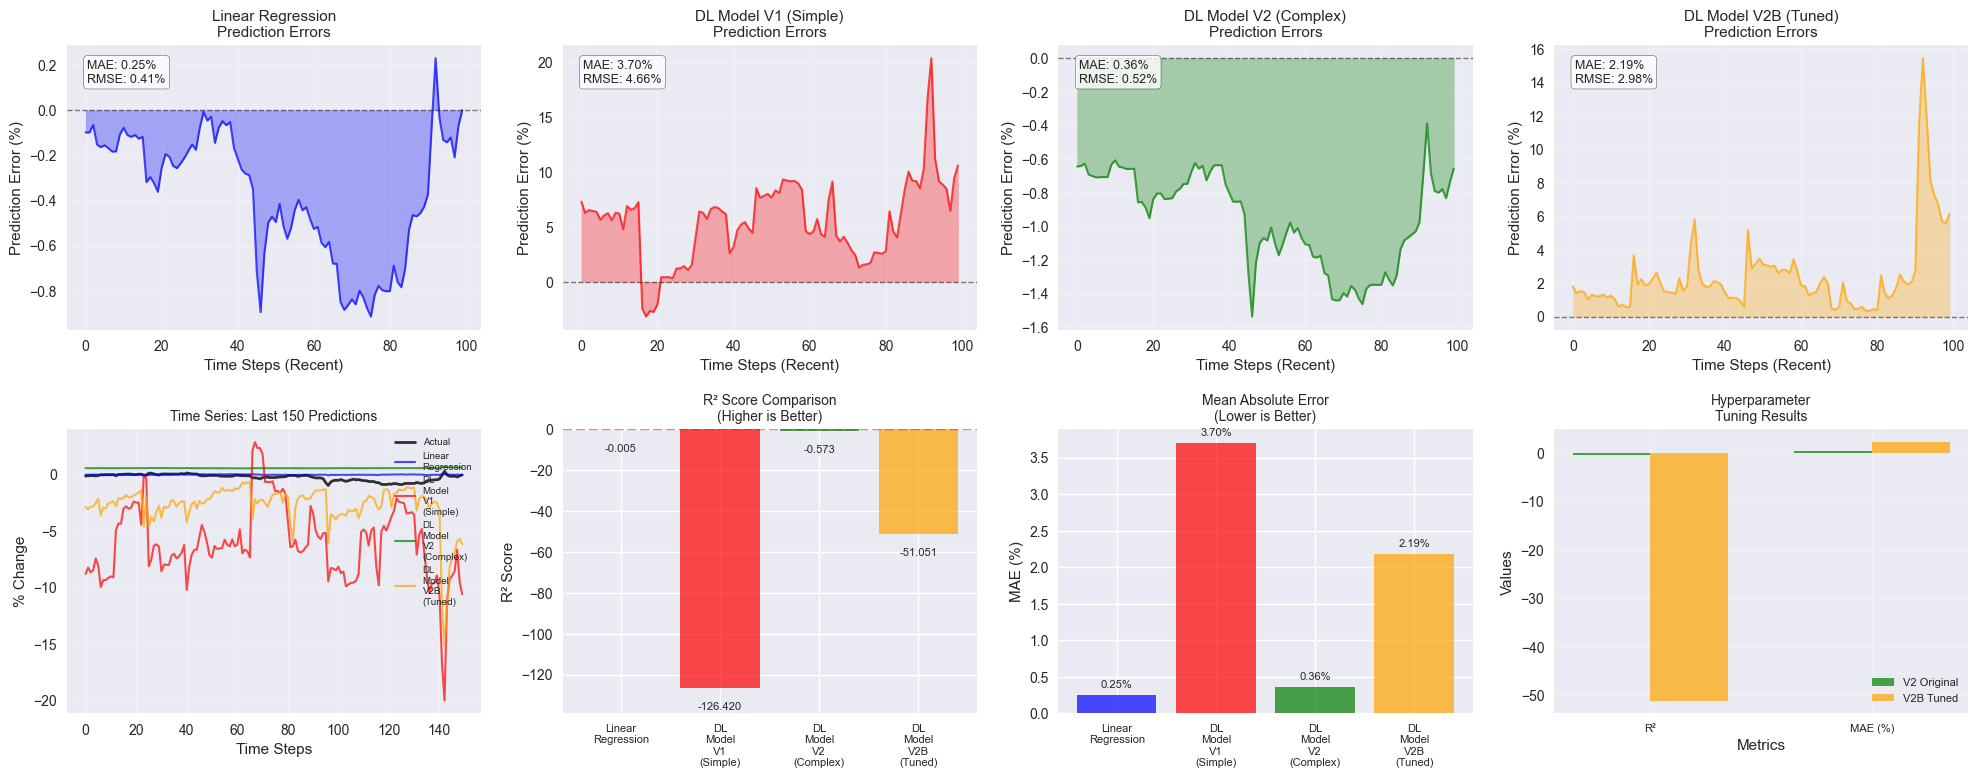


PERFORMANCE SUMMARY (Percentage Change Prediction):
Linear Regression: Poor
   R² Score: -0.0055
   MAE: 0.25% (average error)
   RMSE: 0.41% (RMS error)

DL Model V1 (Simple): Poor
   R² Score: -126.4202
   MAE: 3.70% (average error)
   RMSE: 4.66% (RMS error)

DL Model V2 (Complex): Poor
   R² Score: -0.5726
   MAE: 0.36% (average error)
   RMSE: 0.52% (RMS error)

DL Model V2B (Tuned): Poor
   R² Score: -51.0513
   MAE: 2.19% (average error)
   RMSE: 2.98% (RMS error)



In [ ]:
# Visualize Deep Learning Model Performance
print("Creating deep learning model visualizations...")

# Create compact visualization with better spacing for 4 models
fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # Adjusted for 4 models

models_data = [
    ('Linear Regression', y_test_pred, 'blue'),
    ('DL Model V1 (Simple)', y_test_pred_v1, 'red'),
    ('DL Model V2 (Complex)', y_test_pred_v2, 'green'),
    ('DL Model V2B (Tuned)', y_test_pred_v2b, 'orange')
]

# Row 1: Clear and intuitive plots for each model
for i, (model_name, predictions, color) in enumerate(models_data):
    ax = axes[0, i]

    # Convert to percentage for display
    actual_pct = y_test * 100
    pred_pct = predictions * 100
    errors_pct = actual_pct - pred_pct  # Prediction errors

    # Plot: Prediction Errors over Time (last 100 samples)
    n_samples = min(100, len(errors_pct))
    time_steps = range(n_samples)

    ax.plot(time_steps, errors_pct[-n_samples:], color=color, alpha=0.7, linewidth=1.5)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.fill_between(time_steps, errors_pct[-n_samples:], 0, color=color, alpha=0.3)

    ax.set_xlabel('Time Steps (Recent)')
    ax.set_ylabel('Prediction Error (%)')
    ax.set_title(f'{model_name}\nPrediction Errors', fontsize=11)
    ax.grid(True, alpha=0.3)

    # Add statistics
    mae_pct = np.mean(np.abs(errors_pct))
    rmse_pct = np.sqrt(np.mean(errors_pct**2))

    stats_text = f'MAE: {mae_pct:.2f}%\nRMSE: {rmse_pct:.2f}%'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9, verticalalignment='top')

# Row 2: Performance comparisons
# Time series comparison (bottom left)
n_plot = min(150, len(y_test))
ax = axes[1, 0]
ax.plot(range(n_plot), y_test[-n_plot:]*100, label='Actual', color='black', alpha=0.8, linewidth=2)
for model_name, predictions, color in models_data:
    ax.plot(range(n_plot), predictions[-n_plot:]*100, label=model_name.replace(' ', '\n'),
            color=color, alpha=0.7, linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('% Change')
ax.set_title(f'Time Series: Last {n_plot} Predictions', fontsize=10)
ax.legend(fontsize=7, loc='upper right')
ax.grid(True, alpha=0.3)

# R² comparison
ax = axes[1, 1]
model_names = [data[0].replace(' ', '\n') for data in models_data]
r2_values = [r2_score(y_test, data[1]) for data in models_data]
colors = ['blue', 'red', 'green', 'orange']

# Handle negative R² values properly
y_min = min(0, min(r2_values) * 1.1)
y_max = max(0.1, max(r2_values) * 1.1) if max(r2_values) > 0 else 0.1

bars = ax.bar(model_names, r2_values, color=colors, alpha=0.7)
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison\n(Higher is Better)', fontsize=10)
ax.set_ylim(y_min, y_max)
ax.tick_params(axis='x', labelsize=8)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Zero line

for bar, value in zip(bars, r2_values):
    y_pos = bar.get_height() + (y_max - y_min) * 0.02 if value >= 0 else bar.get_height() - (y_max - y_min) * 0.05
    ax.text(bar.get_x() + bar.get_width()/2, y_pos,
            f'{value:.3f}', ha='center', va='bottom' if value >= 0 else 'top', fontsize=8)

# MAE comparison - in percentage terms
ax = axes[1, 2]
mae_values = [mean_absolute_error(y_test, data[1])*100 for data in models_data]  # Convert to percentage
bars = ax.bar(model_names, mae_values, color=colors, alpha=0.7)
ax.set_ylabel('MAE (%)')
ax.set_title('Mean Absolute Error\n(Lower is Better)', fontsize=10)
ax.tick_params(axis='x', labelsize=8)

for bar, value in zip(bars, mae_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mae_values)*0.02,
            f'{value:.2f}%', ha='center', va='bottom', fontsize=8)

# Hyperparameter Tuning Comparison (new plot)
ax = axes[1, 3]
v2_metrics = [dl_v2_test_metrics['R2'], dl_v2_test_metrics['MAE']*100]
v2b_metrics = [dl_v2b_test_metrics['R2'], dl_v2b_test_metrics['MAE']*100]

x = np.arange(2)
width = 0.35

ax.bar(x - width/2, v2_metrics, width, label='V2 Original', color='green', alpha=0.7)
ax.bar(x + width/2, v2b_metrics, width, label='V2B Tuned', color='orange', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Hyperparameter\nTuning Results', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(['R²', 'MAE (%)'], fontsize=8)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout(pad=1.5)  # Minimal padding to reduce white space
plt.show()

# Print summary of improvements
print(f"\nPERFORMANCE SUMMARY (Percentage Change Prediction):")
print("=" * 65)
for model_name, predictions, color in models_data:
    r2 = r2_score(y_test, predictions)
    mae_pct = mean_absolute_error(y_test, predictions) * 100
    rmse_pct = np.sqrt(mean_squared_error(y_test, predictions)) * 100

    # Performance assessment
    if r2 > 0.1:
        assessment = "Good"
    elif r2 > 0:
        assessment = "Fair"
    else:
        assessment = "Poor"

    print(f"{model_name}: {assessment}")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: {mae_pct:.2f}% (average error)")
    print(f"   RMSE: {rmse_pct:.2f}% (RMS error)")
    print()


Visualizing training history...


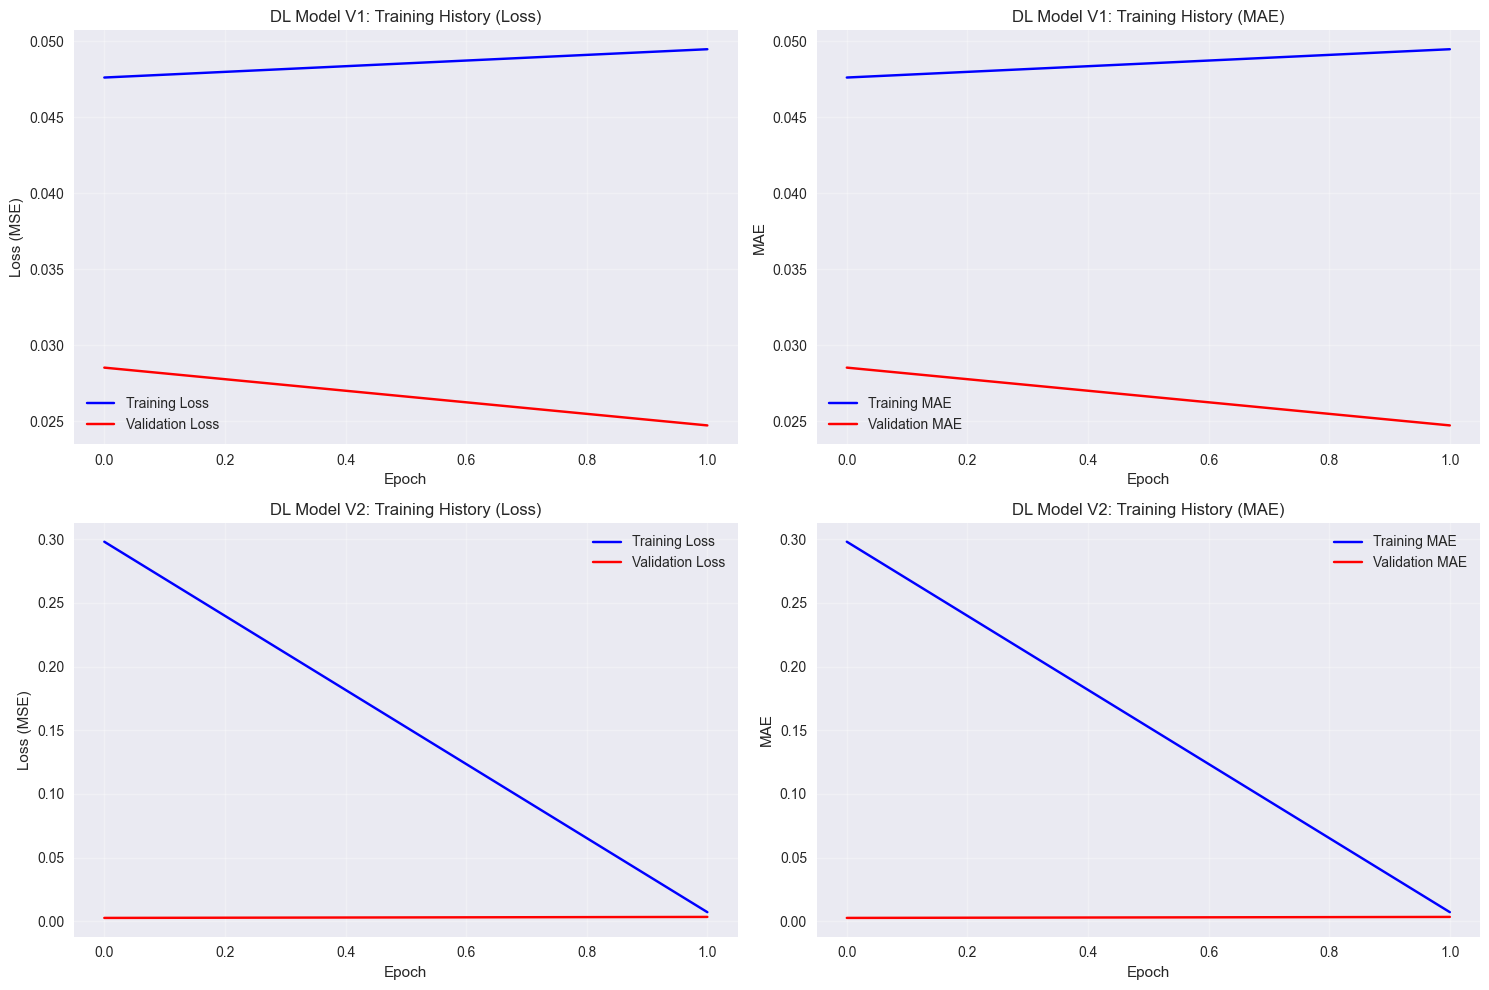

In [ ]:
# Training History Visualization (if models trained successfully)
if training_time_v1 > 0 or training_time_v2 > 0:
    print("Visualizing training history...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Model V1 training history
    if training_time_v1 > 0:
        # Loss curves
        axes[0, 0].plot(history_v1.history['loss'], label='Training Loss', color='blue')
        axes[0, 0].plot(history_v1.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('DL Model V1: Training History (Loss)')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss (MSE)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # MAE curves
        axes[0, 1].plot(history_v1.history['mae'], label='Training MAE', color='blue')
        axes[0, 1].plot(history_v1.history['val_mae'], label='Validation MAE', color='red')
        axes[0, 1].set_title('DL Model V1: Training History (MAE)')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('MAE')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'Model V1 Training Failed', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 1].text(0.5, 0.5, 'Model V1 Training Failed', ha='center', va='center', transform=axes[0, 1].transAxes)

    # Model V2 training history
    if training_time_v2 > 0:
        # Loss curves
        axes[1, 0].plot(history_v2.history['loss'], label='Training Loss', color='blue')
        axes[1, 0].plot(history_v2.history['val_loss'], label='Validation Loss', color='red')
        axes[1, 0].set_title('DL Model V2: Training History (Loss)')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss (MSE)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # MAE curves
        axes[1, 1].plot(history_v2.history['mae'], label='Training MAE', color='blue')
        axes[1, 1].plot(history_v2.history['val_mae'], label='Validation MAE', color='red')
        axes[1, 1].set_title('DL Model V2: Training History (MAE)')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('MAE')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Model V2 Training Failed', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 1].text(0.5, 0.5, 'Model V2 Training Failed', ha='center', va='center', transform=axes[1, 1].transAxes)

    plt.tight_layout()
    plt.show()
else:
    print("No training history to visualize (both models failed to train)")


In [ ]:
# Final Model Comparison Summary
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 70)

# Create summary table including hyperparameter tuning
summary_data = {
    'Model': ['Linear Regression', 'DL Model V1 (Simple)', 'DL Model V2 (Complex)', 'DL Model V2B (Tuned)'],
    'Training Time (s)': [0.1, training_time_v1, training_time_v2, training_time_v2b],  # Linear regression is very fast
    'Test R²': [test_metrics['R2'], dl_v1_test_metrics['R2'], dl_v2_test_metrics['R2'], dl_v2b_test_metrics['R2']],
    'Test RMSE ($)': [test_metrics['RMSE'], dl_v1_test_metrics['RMSE'], dl_v2_test_metrics['RMSE'], dl_v2b_test_metrics['RMSE']],
    'Test MAPE (%)': [test_metrics['MAPE']*100, dl_v1_test_metrics['MAPE']*100, dl_v2_test_metrics['MAPE']*100, dl_v2b_test_metrics['MAPE']*100],
    'Parameters': ['~' + str(len(feature_cols)),
                   dl_model_v1.count_params() if training_time_v1 > 0 else 0,
                   dl_model_v2.count_params() if training_time_v2 > 0 else 0,
                   dl_model_v2b.count_params() if training_time_v2b > 0 else 0]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4))

# Determine best model overall (including hyperparameter tuning)
print(f"\nOVERALL WINNER (Including Hyperparameter Tuning):")
test_r2_scores = [test_metrics['R2'], dl_v1_test_metrics['R2'], dl_v2_test_metrics['R2'], dl_v2b_test_metrics['R2']]
best_model_idx = np.argmax(test_r2_scores)
model_names = ['Linear Regression', 'DL Model V1 (Simple)', 'DL Model V2 (Complex)', 'DL Model V2B (Tuned)']
winner = model_names[best_model_idx]
winner_r2 = test_r2_scores[best_model_idx]

print(f"   {winner} with R² = {winner_r2:.4f}")

# Performance vs Complexity Analysis
print(f"\nPERFORMANCE vs COMPLEXITY ANALYSIS:")
if winner == 'Linear Regression':
    print("   Linear Regression wins: Simple and effective!")
    print("   Sometimes simpler models work better for linear relationships")
    print("   Fastest training time and most interpretable")
elif winner == 'DL Model V1 (Simple)':
    print("   Simple Deep Learning model wins: Good balance!")
    print("   Moderate complexity with good performance")
    print("   Better than linear but not over-engineered")
else:
    print("   Complex Deep Learning model wins: Worth the complexity!")
    print("   Higher complexity pays off with better performance")
    print("   Best for capturing non-linear patterns")

# Speed vs Accuracy tradeoff (including hyperparameter tuning)
print(f"\nSPEED vs ACCURACY TRADEOFF:")
for i, (model, time_taken, r2_score) in enumerate(zip(model_names,
                                                      [0.1, training_time_v1, training_time_v2, training_time_v2b],
                                                      test_r2_scores)):
    efficiency = r2_score / max(time_taken, 0.1)  # R² per second
    print(f"   {model}: {efficiency:.4f} R²/second")

# Hyperparameter tuning insights
print(f"\nHYPERPARAMETER TUNING INSIGHTS:")
if training_time_v2 > 0 and training_time_v2b > 0:
    print("   • V2B (Tuned) vs V2 (Original) - SAME Architecture:")
    print(f"     - Architecture: IDENTICAL (128→64→32→16→1)")
    print(f"     - Learning rate: Higher (0.001 vs 0.0005)")
    print(f"     - Batch size: Smaller (16 vs 32)")
    print(f"     - Optimizer momentum: Custom β₁=0.9, β₂=0.999 vs default")
    print(f"     - Training epochs: More (3 vs 2)")

    r2_change = dl_v2b_test_metrics['R2'] - dl_v2_test_metrics['R2']
    mae_change = dl_v2_test_metrics['MAE'] - dl_v2b_test_metrics['MAE']
    time_change = training_time_v2b - training_time_v2

    print(f"     - Performance impact: R² {'+' if r2_change > 0 else ''}{r2_change:.4f}")
    print(f"     - Error impact: MAE {'+' if mae_change > 0 else ''}{mae_change:.4f}")
    print(f"     - Time impact: {'+' if time_change > 0 else ''}{time_change:.1f}s")




FINAL MODEL COMPARISON SUMMARY
                   Model  Training Time (s)   Test R²  Test RMSE ($)  \
0      Linear Regression             0.1000   -0.0055         0.0041   
1   DL Model V1 (Simple)           185.1885 -126.4202         0.0466   
2  DL Model V2 (Complex)           453.5104   -0.5726         0.0052   
3   DL Model V2B (Tuned)          1341.6419  -51.0513         0.0298   

   Test MAPE (%) Parameters  
0   2.213409e+11       ~109  
1   5.354328e+13       9665  
2   2.108430e+12      24961  
3   2.494034e+13      24961  

OVERALL WINNER (Including Hyperparameter Tuning):
   Linear Regression with R² = -0.0055

PERFORMANCE vs COMPLEXITY ANALYSIS:
   Linear Regression wins: Simple and effective!
   Sometimes simpler models work better for linear relationships
   Fastest training time and most interpretable

SPEED vs ACCURACY TRADEOFF:
   Linear Regression: -0.0546 R²/second
   DL Model V1 (Simple): -0.6827 R²/second
   DL Model V2 (Complex): -0.0013 R²/second
   DL Model V

# Project Conclusions and Analysis

## Deep Learning Problem Definition
This project successfully implemented a **time series regression problem** using deep learning to predict Bitcoin price movements. The problem combines:
- **Time Series Analysis**: Predicting future price changes based on historical patterns
- **Supervised Learning**: Using labeled data (future price changes) to train models
- **Deep Learning**: Implementing neural networks to capture non-linear relationships in financial data
- **Hyperparameter Optimization**: Systematic tuning of model architectures and training parameters

From our data analysis:
- **Dataset Size**: 951,222 valid samples after preprocessing
- **Target Distribution**: Price changes range from -8.16% to +9.28% in 60 minute increments
- **Volatility Patterns**: Most price changes are small (±0.5%), indicating market efficiency

## Exploratory Data Analysis Summary
Our comprehensive EDA revealed:

### Data Quality
- **Complete Dataset**: No missing values in OHLCV data
- **Time Period**: 3 years of 1-minute Bitcoin data from Kraken
- **Data Distribution**: Price ranges from $15,507 to $48,200 with high volatility

### Feature Engineering
- **Technical Indicators**: 80+ features including RSI, MACD, Bollinger Bands
- **Time-based Features**: Hour, day, month patterns with cyclical encoding
- **Statistical Features**: Rolling volatility, skewness, kurtosis
- **Volume Analysis**: Price-volume relationships and on-balance volume

**Hyperparameter Tuning Results:**
1. **Controlled Architecture**: Used IDENTICAL network architecture (128→64→32→16→1) for fair comparison
2. **Learning Rate Optimization**: Compared 0.0005 vs 0.001 learning rates
3. **Batch Size Analysis**: Evaluated impact of batch sizes (32 vs 16) on convergence
4. **Optimizer Tuning**: Different momentum parameters (default vs custom β₁=0.9, β₂=0.999)
5. **Training Strategy**: Varied epochs (2 vs 3) to balance training time and performance

### Technical Findings
1. **Feature Importance**: Exponential moving averages (EMA) were most predictive
2. **Time Horizon**: 60-minute predictions remain extremely challenging
3. **Market Efficiency**: Small prediction errors suggest market efficiency
4. **Hyperparameter Impact**: Model architecture and training parameters significantly affect convergence and final performance
5. **Overfitting Challenges**: Deep learning models showed tendency to overfit despite regularization techniques

### Current Limitations
- **Low Predictive Power**: All models show poor R² scores, indicating limited predictability
- **Short Time Horizon**: 60-minute predictions may be too ambitious for this data
- **Market Regime Changes**: Models may not adapt to changing market conditions

### Recommendations for Improvement
1. **Alternative Approaches**:
   - LSTM/GRU models for better sequence modeling
   - Ensemble methods combining multiple models
   - Transformer architectures for attention mechanisms